# Cinema LSTM

----

Starting from Panda and Numpy

In [3]:
# pandas as pd
try:
    import pandas as pd
    print('Pandas already installed, only imported')
except:
    !pip install pandas
    import pandas as pd
    print('Pandas was not installed, installed and imported')
    
# numpy as np
try:
    import numpy as np
    print('NumPy already installed, only imported')
except:
    !pip install numpy
    import numpy as np
    print('NumPy was not installed, installed and imported')
    
# pyplot as plt
try:
    import matplotlib.pyplot as plt
    print('PyPlot already installed, only imported')
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    print('PyPlot was not installed, installed and imported')    


import tensorflow as tf


Pandas already installed, only imported
NumPy already installed, only imported
PyPlot already installed, only imported


In [4]:
cinema = pd.read_csv('../data/RAW Cinema Data.csv', sep=';', low_memory=False)

# Mapping dictionary for translating Dutch day names to English
dutch_to_english = {
    'Zondag': 'Sunday',
    'maandag': 'Monday',
    'dinsdag': 'Tuesday',
    'woensdag': 'Wednesday',
    'donderdag': 'Thursday',
    'vrijdag': 'Friday',
    'zaterdag': 'Saturday'
}

# Translate Dutch day names to English
cinema['Day'] = cinema['Day'].map(dutch_to_english)

# Convert the "Date" column to datetime
cinema['Date'] = pd.to_datetime(cinema['Date'], format='%d/%m/%Y')

# Drop rows with missing values in the "Visitor" column
cinema = cinema.dropna(subset=['Visitor'])

# Convert the "Visitor" column to numeric to check for non-numeric values
cinema['Visitor'] = pd.to_numeric(cinema['Visitor'], errors='coerce')

# Drop rows with non-numeric values in the "Visitor" column
cinema = cinema.dropna(subset=['Visitor'])

# Convert the "Visitor" column to integer
cinema['Visitor'] = cinema['Visitor'].astype(int)

# Extract each column into separate variables
day_categorical = cinema['Day'].astype('category')
date = cinema['Date']
visitor = cinema['Visitor']

In [5]:
cinema.head()

,Day,Date,Visitor
0,Sunday,2023-01-01,484
1,Monday,2023-01-02,832
2,Tuesday,2023-01-03,872
3,Wednesday,2023-01-04,1003
4,Thursday,2023-01-05,851


In [6]:
cinema.dtypes

Day                object
Date       datetime64[ns]
Visitor             int32
dtype: object

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'

# Summary statistics for visitor counts
visitor_summary = cinema['Visitor'].describe()

# Print the summary statistics
print(visitor_summary)

count     428.000000
mean      497.616822
std       269.279597
min       107.000000
25%       304.500000
50%       406.500000
75%       653.750000
max      1437.000000
Name: Visitor, dtype: float64


In [8]:
cinema.head()

,Day,Date,Visitor
0,Sunday,2023-01-01,484
1,Monday,2023-01-02,832
2,Tuesday,2023-01-03,872
3,Wednesday,2023-01-04,1003
4,Thursday,2023-01-05,851


Tune Hyperparameters

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Function to create LSTM model
def create_lstm_model(neurons=50, activation='tanh', optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(neurons, activation=activation))
    model.add(Dense(1))
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(cinema['Visitor'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model as a KerasRegressor
model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'neurons': [50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.01],
    'epochs': [50, 100]  # Adjust the number of epochs as needed
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Print best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Get the best model
best_model = grid_result.best_estimator_

# Train the best model
best_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], batch_size=32, verbose=0)

# Evaluate the best model
loss = best_model.score(X_test, y_test)
print(f"LSTM Model Test Loss: {loss}")

C:\Users\mario\AppData\Local\Temp\ipykernel_543168\1622493345.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=adam; total time=   2.1s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=adam; total time=   1.8s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=adam; total time=   1.9s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=50, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=100, optimizer=adam; total time=   2.6s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=100, optimizer=adam; total time=   2.7s
[CV] END activation=relu, epochs=50, learning_rate=0.001, neurons=100, optimizer=adam; t

In [10]:
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense

# scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# # Prepare data for LSTM
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i + seq_length])
#         y.append(data[i + seq_length])
#     return np.array(X), np.array(y)

# # Define sequence length
# seq_length = 7

# # Create sequences for LSTM input
# X, y = create_sequences(scaled_data, seq_length)

# print(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Define LSTM model architecture
# model = Sequential()
# model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# # Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# # Evaluate the model
# loss = model.evaluate(X_test, y_test, verbose=0)
# print(f"LSTM Model Test Loss: {loss}")

# print(X_test)

# # Make predictions
# predictions = model.predict(X_test)

# # Inverse scale the actual values for plotting
# actual_values = y_test.reshape(-1, 1)

# # Plot actual vs. predicted visitor numbers
# y_train_actual = y_train.reshape(-1, 1)

# train_length = len(y_train_actual)

# plt.figure(figsize=(12, 6))
# plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

# plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
# plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

# plt.title('Actual vs. Predicted Visitors')
# plt.xlabel('Time')
# plt.ylabel('Total Devices Max')
# plt.legend()
# plt.show()

NameError: name 'wifi' is not defined

[[[ 484]
  [ 832]
  [ 872]
  ...
  [ 851]
  [ 901]
  [1082]]

 [[ 832]
  [ 872]
  [1003]
  ...
  [ 901]
  [1082]
  [ 727]]

 [[ 872]
  [1003]
  [ 851]
  ...
  [1082]
  [ 727]
  [ 362]]

 ...

 [[ 833]
  [ 382]
  [ 453]
  ...
  [ 416]
  [ 610]
  [ 922]]

 [[ 382]
  [ 453]
  [ 505]
  ...
  [ 610]
  [ 922]
  [ 731]]

 [[ 453]
  [ 505]
  [ 416]
  ...
  [ 922]
  [ 731]
  [ 437]]]
LSTM Model Test Loss: 46280.9921875
3/3 [==============================] - 0s 1ms/step


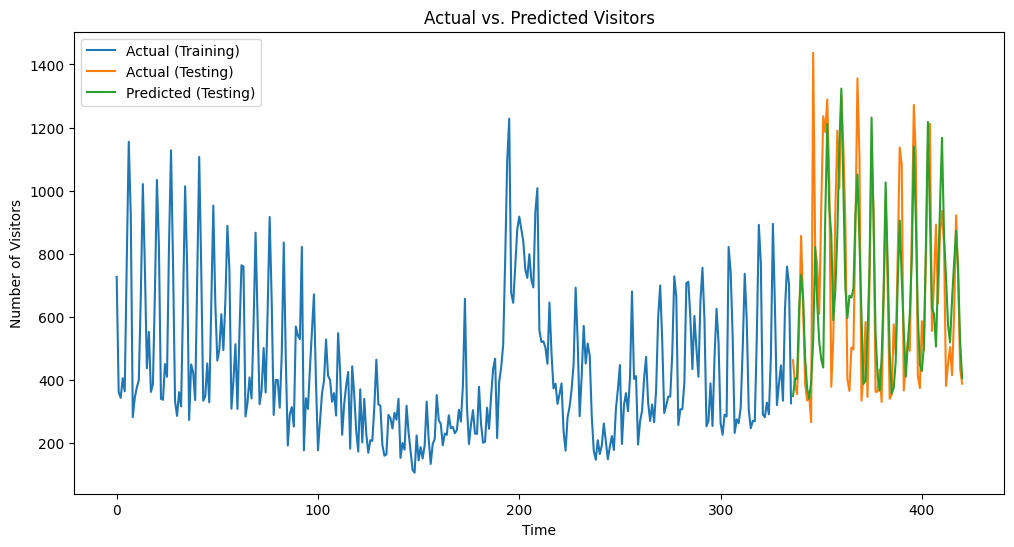

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

scaled_data = cinema['Visitor'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape data to fit LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model architecture
# model = Sequential()
# model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(50, activation='tanh'))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define optimizer with learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse')

# Train the model with specified epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
train_length = len(y_train)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train, label='Actual (Training)')
plt.plot(range(train_length, train_length + len(y_test)), y_test, label='Actual (Testing)')
plt.plot(range(train_length, train_length + len(predictions)), predictions.flatten(), label='Predicted (Testing)')
plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the baseline prediction using the average of actual values
baseline_prediction = np.mean(actual_values)
baseline_predictions = np.full_like(actual_values, baseline_prediction)

# Evaluate the baseline model using Mean Squared Error (MSE)
baseline_mse = mean_squared_error(actual_values, baseline_predictions)
print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")

# Calculate Root Mean Squared Error (RMSE) for the baseline model
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE) for the baseline model
baseline_mape = np.mean(np.abs((actual_values - baseline_predictions) / actual_values)) * 100
print(f"Baseline Mean Absolute Percentage Error (MAPE): {baseline_mape}%")

# Calculate R-squared (coefficient of determination) for the baseline model
baseline_r2 = r2_score(actual_values, predictions)
print(f"Baseline R-squared (Coefficient of Determination): {baseline_r2}")


Baseline Mean Squared Error (MSE): 98437.65882352942
Baseline Root Mean Squared Error (RMSE): 313.7477630574112
Minimum value: 267
Maximum value: 1437
Range: 1170
Baseline Mean Absolute Percentage Error (MAPE): 46.927709089447916%
Baseline R-squared (Coefficient of Determination): 0.529843722862587


In [17]:
#Serialize Model
model.save("cinemadata_model.h5")

#Serialize scaler
# import pickle

# with open('scaler_cinema.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

[[[ 484]
  [ 832]
  [ 872]
  ...
  [ 851]
  [ 901]
  [1082]]

 [[ 832]
  [ 872]
  [1003]
  ...
  [ 901]
  [1082]
  [ 727]]

 [[ 872]
  [1003]
  [ 851]
  ...
  [1082]
  [ 727]
  [ 362]]

 ...

 [[ 833]
  [ 382]
  [ 453]
  ...
  [ 416]
  [ 610]
  [ 922]]

 [[ 382]
  [ 453]
  [ 505]
  ...
  [ 610]
  [ 922]
  [ 731]]

 [[ 453]
  [ 505]
  [ 416]
  ...
  [ 922]
  [ 731]
  [ 437]]]
LSTM Model Test Loss: 30334.46484375
5/5 [==============================] - 0s 1ms/step


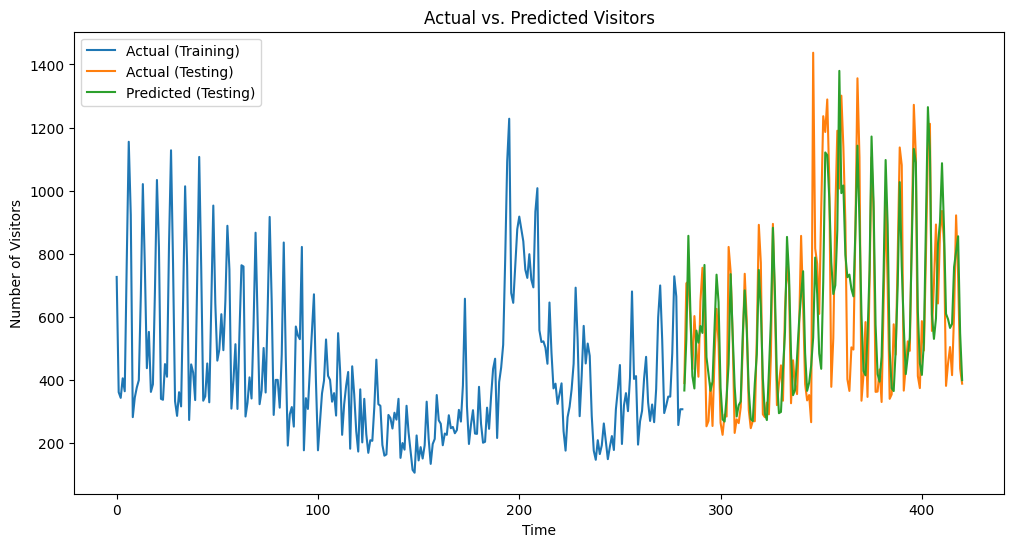

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

scaled_data = cinema['Visitor'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Reshape data to fit LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model architecture
# model = Sequential()
# model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(50, activation='tanh'))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define optimizer with learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse')

# Train the model with specified epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
train_length = len(y_train)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train, label='Actual (Training)')
plt.plot(range(train_length, train_length + len(y_test)), y_test, label='Actual (Testing)')
plt.plot(range(train_length, train_length + len(predictions)), predictions.flatten(), label='Predicted (Testing)')
plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()


In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the baseline prediction using the average of actual values
baseline_prediction = np.mean(actual_values)
baseline_predictions = np.full_like(actual_values, baseline_prediction)

# Evaluate the baseline model using Mean Squared Error (MSE)
baseline_mse = mean_squared_error(actual_values, baseline_predictions)
print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")

# Calculate Root Mean Squared Error (RMSE) for the baseline model
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE) for the baseline model
baseline_mape = np.mean(np.abs((actual_values - baseline_predictions) / actual_values)) * 100
print(f"Baseline Mean Absolute Percentage Error (MAPE): {baseline_mape}%")

# Calculate R-squared (coefficient of determination) for the baseline model
baseline_r2 = r2_score(actual_values, predictions)
print(f"Baseline R-squared (Coefficient of Determination): {baseline_r2}")


Baseline Mean Squared Error (MSE): 87423.3165467626
Baseline Root Mean Squared Error (RMSE): 295.67434205010517
Minimum value: 227
Maximum value: 1437
Range: 1210
Baseline Mean Absolute Percentage Error (MAPE): 48.63205810461074%
Baseline R-squared (Coefficient of Determination): 0.653014956575366


[[[ 484]
  [ 832]
  [ 872]
  ...
  [ 851]
  [ 901]
  [1082]]

 [[ 832]
  [ 872]
  [1003]
  ...
  [ 901]
  [1082]
  [ 727]]

 [[ 872]
  [1003]
  [ 851]
  ...
  [1082]
  [ 727]
  [ 362]]

 ...

 [[ 833]
  [ 382]
  [ 453]
  ...
  [ 416]
  [ 610]
  [ 922]]

 [[ 382]
  [ 453]
  [ 505]
  ...
  [ 610]
  [ 922]
  [ 731]]

 [[ 453]
  [ 505]
  [ 416]
  ...
  [ 922]
  [ 731]
  [ 437]]]
LSTM Model Test Loss: 46280.9921875
3/3 [==============================] - 0s 1ms/step


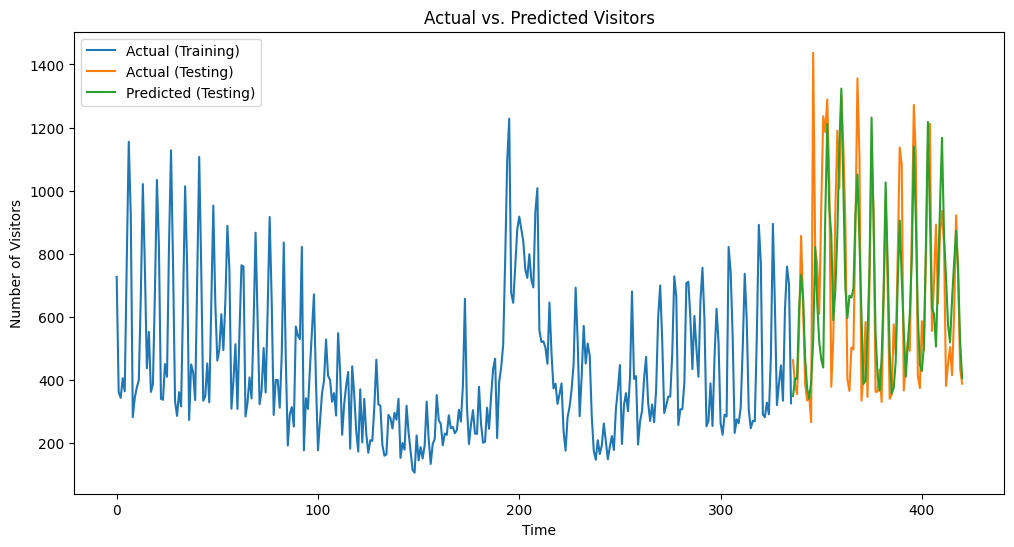

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

scaled_data = cinema['Visitor'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Reshape data to fit LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model architecture
# model = Sequential()
# model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)))
# model.add(LSTM(50, activation='tanh'))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define optimizer with learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse')

# Train the model with specified epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
train_length = len(y_train)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train, label='Actual (Training)')
plt.plot(range(train_length, train_length + len(y_test)), y_test, label='Actual (Testing)')
plt.plot(range(train_length, train_length + len(predictions)), predictions.flatten(), label='Predicted (Testing)')
plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the baseline prediction using the average of actual values
baseline_prediction = np.mean(actual_values)
baseline_predictions = np.full_like(actual_values, baseline_prediction)

# Evaluate the baseline model using Mean Squared Error (MSE)
baseline_mse = mean_squared_error(actual_values, baseline_predictions)
print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")

# Calculate Root Mean Squared Error (RMSE) for the baseline model
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE) for the baseline model
baseline_mape = np.mean(np.abs((actual_values - baseline_predictions) / actual_values)) * 100
print(f"Baseline Mean Absolute Percentage Error (MAPE): {baseline_mape}%")

# Calculate R-squared (coefficient of determination) for the baseline model
baseline_r2 = r2_score(actual_values, predictions)
print(f"Baseline R-squared (Coefficient of Determination): {baseline_r2}")


Baseline Mean Squared Error (MSE): 98437.65882352942
Baseline Root Mean Squared Error (RMSE): 313.7477630574112
Minimum value: 267
Maximum value: 1437
Range: 1170
Baseline Mean Absolute Percentage Error (MAPE): 46.927709089447916%
Baseline R-squared (Coefficient of Determination): 0.529843722862587


Import the data:

In [28]:
wifi_data = pd.read_csv("../data/RAW WiFi Data 6 months.csv", low_memory=False)

In [29]:
wifi_data.head()

,Date Time,Date Time(RAW),Total Online Devices,Total Online Devices(RAW),Speed Bad,Speed Bad(RAW),Speed Good,Speed Good(RAW),Speed Better,Speed Better(RAW),...,Experience Bad,Experience Bad(RAW),Experience Good,Experience Good(RAW),Experience Better,Experience Better(RAW),Downtime,Downtime(RAW),Coverage,Coverage(RAW)
0,1-9-2023 00:00:00 - 01:00:00,45169.958333,61 #,60.9000,"0,57 #",0.5667,"9,88 #",9.8833,50 #,50.4500,...,"0,62 #",0.6167,"0,17 #",0.1667,62 #,62.3667,0 %,0.0,100 %,10000.0
1,1-9-2023 01:00:00 - 02:00:00,45170.000000,58 #,58.3500,"0,85 #",0.8500,11 #,10.7833,47 #,46.7167,...,"0,55 #",0.5500,"0,15 #",0.1500,58 #,58.4500,0 %,0.0,100 %,10000.0
2,1-9-2023 02:00:00 - 03:00:00,45170.041667,57 #,57.3833,"0,47 #",0.4667,"9,73 #",9.7333,47 #,47.1833,...,"0,38 #",0.3833,"0,17 #",0.1667,57 #,56.8333,0 %,0.0,100 %,10000.0
3,1-9-2023 03:00:00 - 04:00:00,45170.083333,57 #,57.4000,"0,52 #",0.5167,10 #,10.4000,46 #,46.4833,...,"0,15 #",0.1500,0 #,0.0000,57 #,57.3667,0 %,0.0,100 %,10000.0
4,1-9-2023 04:00:00 - 05:00:00,45170.125000,57 #,57.1333,"0,30 #",0.3000,10 #,10.4833,46 #,46.3500,...,"0,42 #",0.4167,"0,17 #",0.1667,57 #,56.9667,0 %,0.0,100 %,10000.0


Use only the necessary columns from our dataset:

In [30]:
wifi_data = wifi_data[['Date Time', 'Total Online Devices']]
wifi_data.head()

,Date Time,Total Online Devices
0,1-9-2023 00:00:00 - 01:00:00,61 #
1,1-9-2023 01:00:00 - 02:00:00,58 #
2,1-9-2023 02:00:00 - 03:00:00,57 #
3,1-9-2023 03:00:00 - 04:00:00,57 #
4,1-9-2023 04:00:00 - 05:00:00,57 #


Ok, now let's check if there's any missing values

In [31]:
wifi_data.isnull().sum()

Date Time                0
Total Online Devices    52
dtype: int64

Drop the null values from the dataset:

In [32]:
wifi_data = wifi_data.dropna()
wifi_data.isna().sum()

Date Time               0
Total Online Devices    0
dtype: int64

Convert the value of the total number of the devices to an integer:

In [33]:
wifi_data['Total Online Devices'] = wifi_data['Total Online Devices'].str.replace('#','').astype(int)

Have a look of the chnaged data and check their data type:

In [34]:
wifi_data.head()

,Date Time,Total Online Devices
0,1-9-2023 00:00:00 - 01:00:00,61
1,1-9-2023 01:00:00 - 02:00:00,58
2,1-9-2023 02:00:00 - 03:00:00,57
3,1-9-2023 03:00:00 - 04:00:00,57
4,1-9-2023 04:00:00 - 05:00:00,57


Group all the all data based on the date. Add the total, mean, max and min of the devices conneted on a specific date:

In [35]:
dt = wifi_data['Date Time'].str.split(' ').str[0] 
devices = wifi_data['Total Online Devices']

new_data_wifi_df = pd.DataFrame({'datetime': dt, 'totaldevices': devices})

new_data_wifi_df = new_data_wifi_df[new_data_wifi_df['datetime'] != 'Averages']

new_data_wifi_df['datetime'] = pd.to_datetime(new_data_wifi_df['datetime'], format='%d-%m-%Y')

grouped_data = new_data_wifi_df.groupby('datetime').agg({'totaldevices': ['mean', 'max', 'min']})
grouped_data.columns = grouped_data.columns.map(''.join)

total_devices_sum = new_data_wifi_df.groupby('datetime')['totaldevices'].sum()

sorted_grouped_wifi_data = pd.merge(grouped_data, total_devices_sum, left_index=True, right_index=True)

sorted_grouped_wifi_data.rename(columns={'totaldevices': 'totaldevicessum'}, inplace=True)

sorted_grouped_wifi_data = sorted_grouped_wifi_data.sort_index()

sorted_grouped_wifi_data.head()

,totaldevicesmean,totaldevicesmax,totaldevicesmin,totaldevicessum
datetime,,,,
2023-09-01,104.125000,195,57,2499
2023-09-02,63.625000,72,57,1527
2023-09-03,62.833333,72,58,1508
2023-09-04,162.583333,387,57,3902
2023-09-05,162.583333,377,52,3902


In [36]:
wifi = sorted_grouped_wifi_data.copy()

LSTM Model Test Loss: 0.006272546947002411
[[[0.20791075]
  [0.09964503]
  [0.09001014]
  [0.53296146]
  [0.56110548]
  [0.48681542]
  [0.68737323]]

 [[0.09964503]
  [0.09001014]
  [0.53296146]
  [0.56110548]
  [0.48681542]
  [0.68737323]
  [0.26369168]]

 [[0.09001014]
  [0.53296146]
  [0.56110548]
  [0.48681542]
  [0.68737323]
  [0.26369168]
  [0.10141988]]

 [[0.53296146]
  [0.56110548]
  [0.48681542]
  [0.68737323]
  [0.26369168]
  [0.10141988]
  [0.10344828]]

 [[0.56110548]
  [0.48681542]
  [0.68737323]
  [0.26369168]
  [0.10141988]
  [0.10344828]
  [0.62626775]]

 [[0.48681542]
  [0.68737323]
  [0.26369168]
  [0.10141988]
  [0.10344828]
  [0.62626775]
  [0.65669371]]

 [[0.68737323]
  [0.26369168]
  [0.10141988]
  [0.10344828]
  [0.62626775]
  [0.65669371]
  [0.55400609]]

 [[0.26369168]
  [0.10141988]
  [0.10344828]
  [0.62626775]
  [0.65669371]
  [0.55400609]
  [0.6229716 ]]

 [[0.10141988]
  [0.10344828]
  [0.62626775]
  [0.65669371]
  [0.55400609]
  [0.6229716 ]
  [0.256845

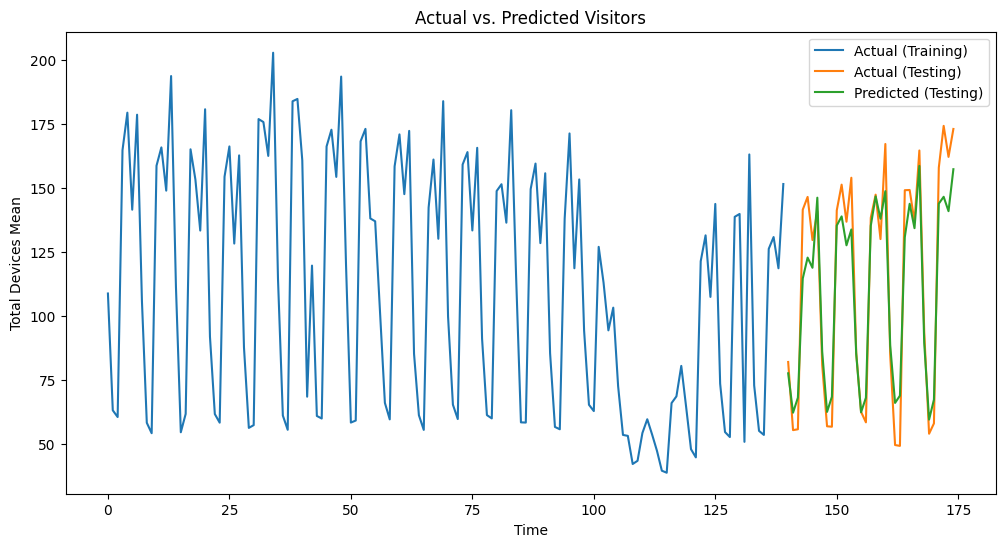

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(wifi['totaldevicesmean'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
wifi_model = Sequential()
wifi_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
wifi_model.add(LSTM(50, activation='relu'))
wifi_model.add(Dense(1))
wifi_model.compile(optimizer='adam', loss='mse')

# Train the model
history = wifi_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = wifi_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

print(X_test)

# Make predictions
predictions = wifi_model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Mean')
plt.legend()
plt.show()

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 169.39284662298837
Root Mean Squared Error (RMSE): 13.015100715053586
Minimum value: 49.083333333333336
Maximum value: 174.29166666666666
Range: 125.20833333333331
Mean Absolute Percentage Error (MAPE): 10.615619836397656%
R-squared (Coefficient of Determination): 0.9119352745406683


LSTM Model Test Loss: 0.0020766868256032467
[[[0.6875  ]
  [0.71875 ]
  [0.703125]
  [0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]]

 [[0.71875 ]
  [0.703125]
  [0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]]

 [[0.703125]
  [0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]]

 [[0.703125]
  [0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]]

 [[0.734375]
  [0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]]

 [[0.796875]
  [0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]]

 [[0.75    ]
  [0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]]

 [[0.8125  ]
  [0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]
  [0.8125  ]]

 [[0.765625]
  [0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]
  [0.8125  ]
  [0.78125 ]]

 [[0.765625]
  [0.765625]
  [0.78125 ]
  [0.6875  ]
  [0.8125  ]
  [0.78125 ]
  [0.75    ]]

 [[0.765625]
  [0.78125 ]


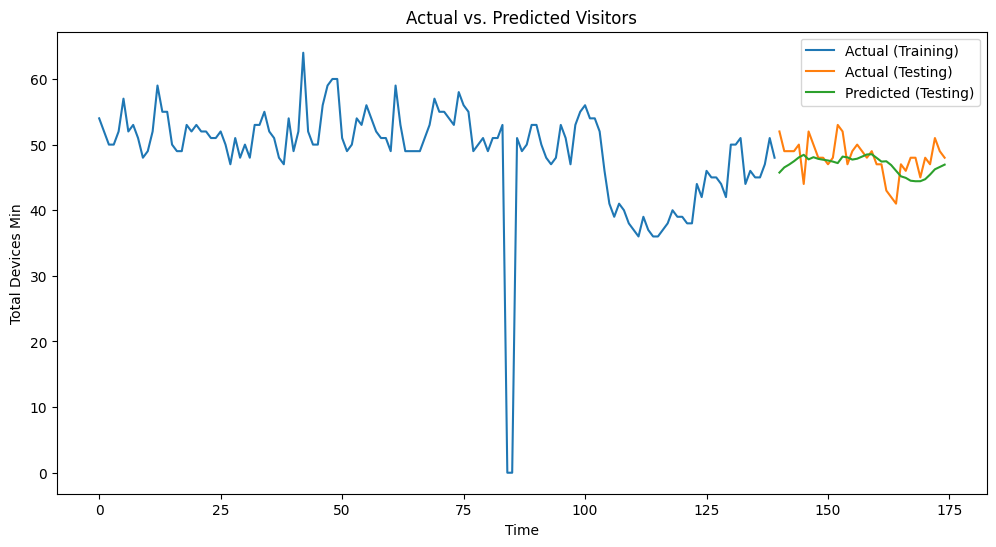

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(wifi['totaldevicesmin'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

print(X_test)

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)

# Inverse scale the actual values for plotting
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted visitor numbers
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Min')
plt.legend()
plt.show()

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 8.506113611128862
Root Mean Squared Error (RMSE): 2.916524234620529
Minimum value: 41.0
Maximum value: 53.0
Range: 12.0
Mean Absolute Percentage Error (MAPE): 4.888747151713059%
R-squared (Coefficient of Determination): -0.21021941621752127


[[[195]
  [ 72]
  [ 72]
  ...
  [377]
  [298]
  [442]]

 [[ 72]
  [ 72]
  [387]
  ...
  [298]
  [442]
  [227]]

 [[ 72]
  [387]
  [377]
  ...
  [442]
  [227]
  [ 83]]

 ...

 [[366]
  [351]
  [429]
  ...
  [ 72]
  [ 74]
  [385]]

 [[351]
  [429]
  [196]
  ...
  [ 74]
  [385]
  [443]]

 [[429]
  [196]
  [ 72]
  ...
  [385]
  [443]
  [390]]]
LSTM Model Test Loss: 3853.600830078125
[[[109]
  [ 65]
  [ 72]
  [289]
  [302]
  [261]
  [351]]

 [[ 65]
  [ 72]
  [289]
  [302]
  [261]
  [351]
  [136]]

 [[ 72]
  [289]
  [302]
  [261]
  [351]
  [136]
  [ 65]]

 [[289]
  [302]
  [261]
  [351]
  [136]
  [ 65]
  [ 65]]

 [[302]
  [261]
  [351]
  [136]
  [ 65]
  [ 65]
  [336]]

 [[261]
  [351]
  [136]
  [ 65]
  [ 65]
  [336]
  [351]]

 [[351]
  [136]
  [ 65]
  [ 65]
  [336]
  [351]
  [292]]

 [[136]
  [ 65]
  [ 65]
  [336]
  [351]
  [292]
  [301]]

 [[ 65]
  [ 65]
  [336]
  [351]
  [292]
  [301]
  [136]]

 [[ 65]
  [336]
  [351]
  [292]
  [301]
  [136]
  [ 73]]

 [[336]
  [351]
  [292]
  [301]
  [136

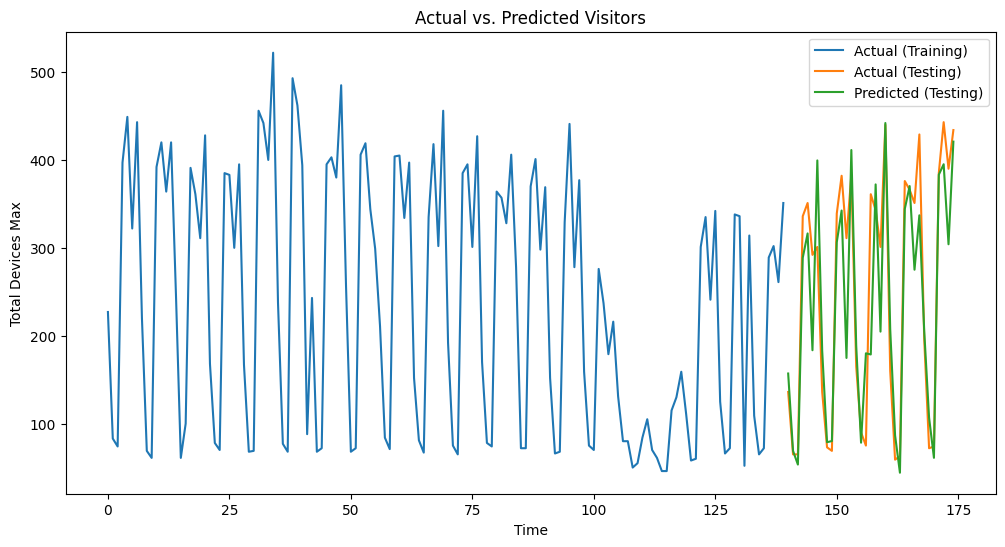

In [41]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

print(X_test)

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 3853.6012781093305
Root Mean Squared Error (RMSE): 62.07738137284248
Minimum value: 59
Maximum value: 443
Range: 384
Mean Absolute Percentage Error (MAPE): 22.507515290169753%
R-squared (Coefficient of Determination): 0.8004468026976179


In [43]:
# Save WiFi Model

#model.save("wifidata_model.h5")

In [1]:
# pandas as pd
try:
    import pandas as pd
    print('Pandas already installed, only imported')
except:
    !pip install pandas
    import pandas as pd
    print('Pandas was not installed, installed and imported')
    
# numpy as np
try:
    import numpy as np
    print('NumPy already installed, only imported')
except:
    !pip install numpy
    import numpy as np
    print('NumPy was not installed, installed and imported')
    
# pyplot as plt
try:
    import matplotlib.pyplot as plt
    print('PyPlot already installed, only imported')
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    print('PyPlot was not installed, installed and imported')    


import tensorflow as tf


Pandas already installed, only imported
NumPy already installed, only imported
PyPlot already installed, only imported


In [17]:
wifi_data = pd.read_csv("../data/RAW WiFi Data 6 months.csv", low_memory=False)

In [18]:
wifi_data = wifi_data[['Date Time', 'Total Online Devices']]
wifi_data = wifi_data.drop(wifi_data.index[-1])
wifi_data.tail()

,Date Time,Total Online Devices
4364,29-2-2024 19:00:00 - 20:00:00,65 #
4365,29-2-2024 20:00:00 - 21:00:00,63 #
4366,29-2-2024 21:00:00 - 22:00:00,65 #
4367,29-2-2024 22:00:00 - 23:00:00,60 #
4368,29-2-2024 23:00:00 - 00:00:00,55 #


In [19]:
wifi_data = wifi_data.dropna()
wifi_data.isna().sum()

Date Time               0
Total Online Devices    0
dtype: int64

In [20]:
from datetime import datetime
def convert_to_datetime(row):
    datetime_string = row.split(" - ")[0]
    datetime_format = "%d-%m-%Y %H:%M:%S"
    return datetime.strptime(datetime_string, datetime_format)

In [21]:
wifi_data['Date Time'] = wifi_data['Date Time'].apply(convert_to_datetime)

In [22]:
wifi_data.head()

,Date Time,Total Online Devices
0,2023-09-01 00:00:00,61 #
1,2023-09-01 01:00:00,58 #
2,2023-09-01 02:00:00,57 #
3,2023-09-01 03:00:00,57 #
4,2023-09-01 04:00:00,57 #


In [23]:
wifi_data['Total Online Devices'] = wifi_data['Total Online Devices'].str.replace('#','').astype(int)

In [24]:
wifi_data.head()

,Date Time,Total Online Devices
0,2023-09-01 00:00:00,61
1,2023-09-01 01:00:00,58
2,2023-09-01 02:00:00,57
3,2023-09-01 03:00:00,57
4,2023-09-01 04:00:00,57


In [25]:
wifi_data.dtypes

Date Time               datetime64[ns]
Total Online Devices             int32
dtype: object

In [26]:
dt = wifi_data['Date Time']
devices = wifi_data['Total Online Devices']

new_data_wifi_df = pd.DataFrame({'datetime': dt, 'totaldevices': devices})

new_data_wifi_df = new_data_wifi_df[new_data_wifi_df['datetime'] != 'Averages']

new_data_wifi_df['datetime'] = pd.to_datetime(new_data_wifi_df['datetime'], format='%d-%m-%Y')

grouped_data = new_data_wifi_df.groupby('datetime').agg({'totaldevices': ['mean', 'max', 'min']})
grouped_data.columns = grouped_data.columns.map(''.join)

total_devices_sum = new_data_wifi_df.groupby('datetime')['totaldevices'].sum()

sorted_grouped_wifi_data = pd.merge(grouped_data, total_devices_sum, left_index=True, right_index=True)

sorted_grouped_wifi_data.rename(columns={'totaldevices': 'totaldevicessum'}, inplace=True)

sorted_grouped_wifi_data = sorted_grouped_wifi_data.sort_index()

sorted_grouped_wifi_data.tail()

,totaldevicesmean,totaldevicesmax,totaldevicesmin,totaldevicessum
datetime,,,,
2024-02-29 19:00:00,65.0,65,65,65
2024-02-29 20:00:00,63.0,63,63,63
2024-02-29 21:00:00,65.0,65,65,65
2024-02-29 22:00:00,60.0,60,60,60
2024-02-29 23:00:00,55.0,55,55,55


In [27]:
wifi = sorted_grouped_wifi_data.copy()

Splitting the test data for a month:

[[[ 61]
  [ 58]
  [ 57]
  ...
  [ 57]
  [ 58]
  [ 58]]

 [[ 58]
  [ 57]
  [ 57]
  ...
  [ 58]
  [ 58]
  [ 59]]

 [[ 57]
  [ 57]
  [ 57]
  ...
  [ 58]
  [ 59]
  [ 75]]

 ...

 [[428]
  [426]
  [301]
  ...
  [105]
  [ 65]
  [ 63]]

 [[426]
  [301]
  [195]
  ...
  [ 65]
  [ 63]
  [ 65]]

 [[301]
  [195]
  [105]
  ...
  [ 63]
  [ 65]
  [ 60]]]
LSTM Model Test Loss: 162.07252502441406
27/27 [==============================] - 0s 1ms/step


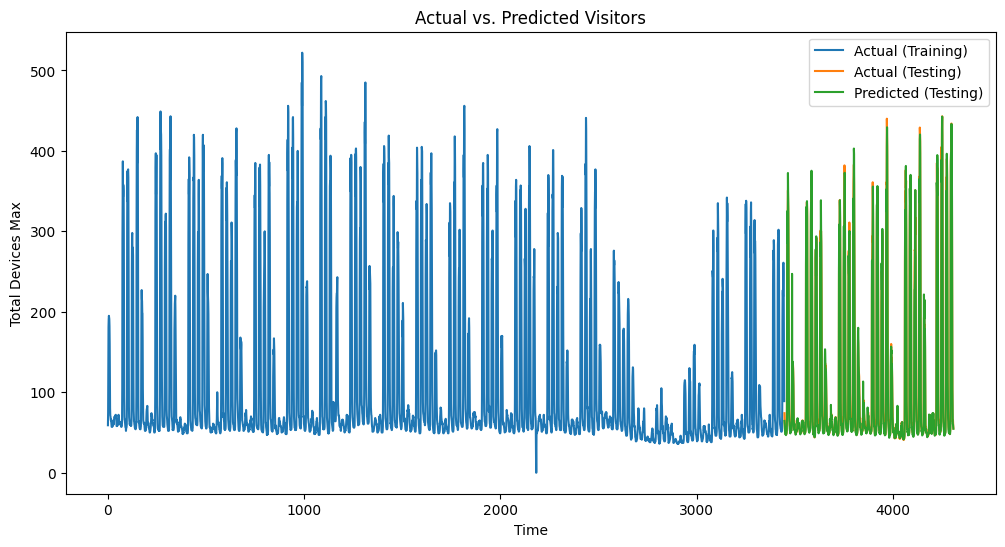

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 162.07252162816275
Root Mean Squared Error (RMSE): 12.730770661203616
Minimum value: 41
Maximum value: 443
Range: 402
Mean Absolute Percentage Error (MAPE): 5.775995179015945%
R-squared (Coefficient of Determination): 0.9853448041305661


Splitting the test data for 2 months:

LSTM Model Test Loss: 141.7707061767578
45/45 [==============================] - 0s 1ms/step


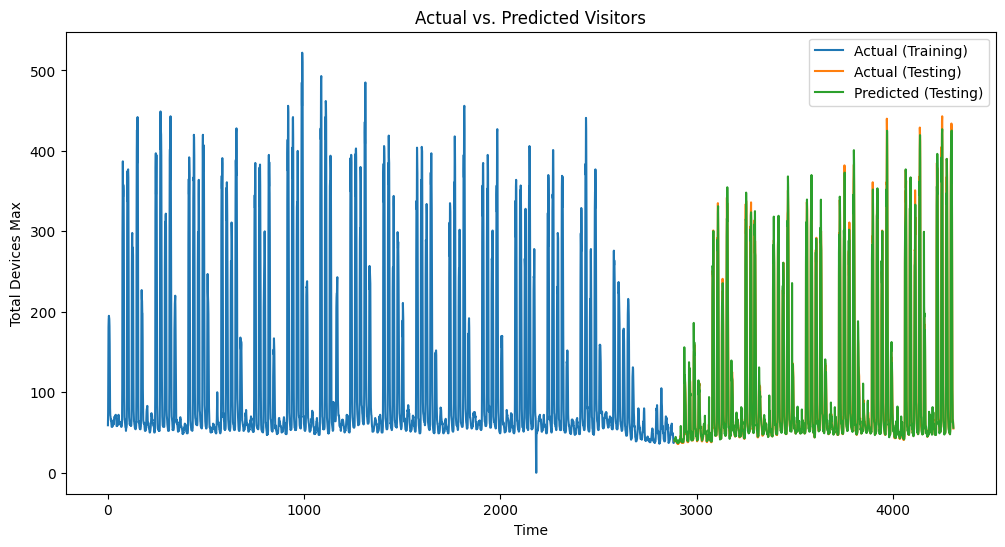

Mean Squared Error (MSE): 141.7707449494403
Root Mean Squared Error (RMSE): 11.90675207390497
Minimum value: 36
Maximum value: 443
Range: 407
Mean Absolute Percentage Error (MAPE): 5.867683546209941%
R-squared (Coefficient of Determination): 0.9846486917939071


In [30]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")#model.save("wifidata_model_hourly.h5")

Splitting the test data for 3 months:

LSTM Model Test Loss: 469.6679382324219
68/68 [==============================] - 0s 1ms/step


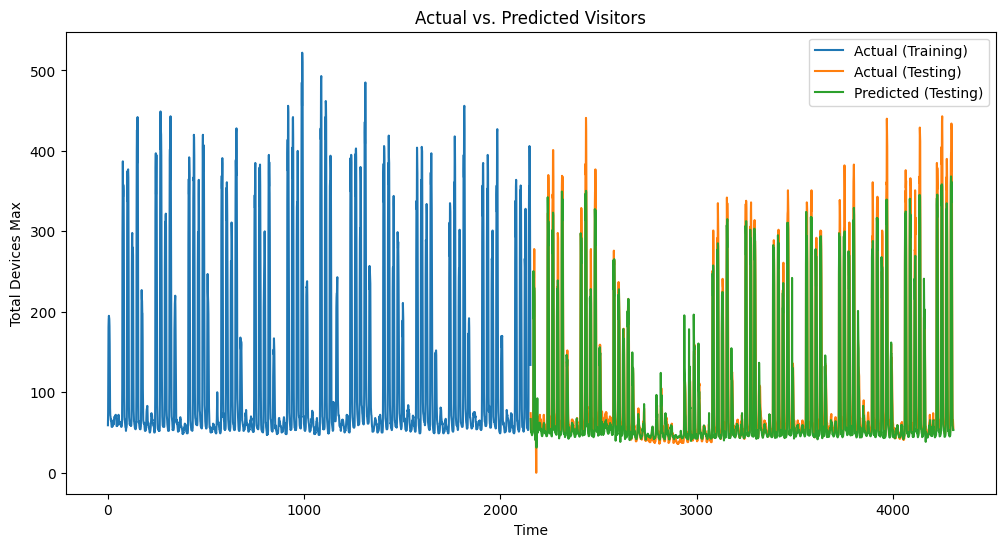

Mean Squared Error (MSE): 469.6679517006128
Root Mean Squared Error (RMSE): 21.67182391264318
Minimum value: 0
Maximum value: 443
Range: 443
Mean Absolute Percentage Error (MAPE): inf%
R-squared (Coefficient of Determination): 0.94341391802415


C:\Users\mario\AppData\Local\Temp\ipykernel_446332\237528664.py:92: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100


In [31]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

In [32]:
#model.save("wifidata_model_hourly.h5")

Splitting the test data for 4 months:

LSTM Model Test Loss: 520.8814086914062
91/91 [==============================] - 0s 1ms/step


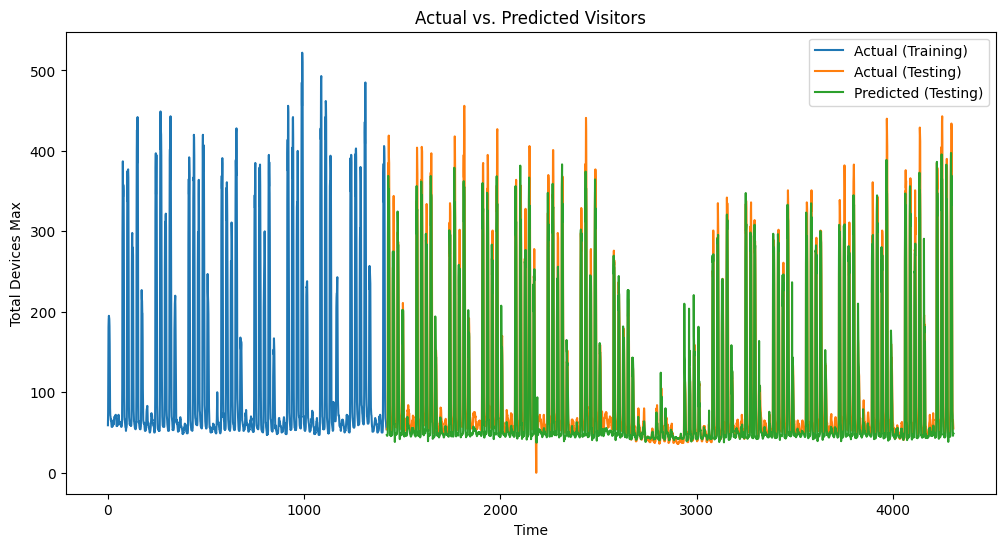

Mean Squared Error (MSE): 520.8814597014184
Root Mean Squared Error (RMSE): 22.82282760092225
Minimum value: 0
Maximum value: 456
Range: 456
Mean Absolute Percentage Error (MAPE): inf%
R-squared (Coefficient of Determination): 0.9436961481104956


C:\Users\mario\AppData\Local\Temp\ipykernel_446332\802077054.py:93: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100


In [33]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.67, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")#model.save("wifidata_model_hourly.h5")

Splitting the test data for 5 months:

LSTM Model Test Loss: 429.6170959472656
114/114 [==============================] - 0s 1ms/step


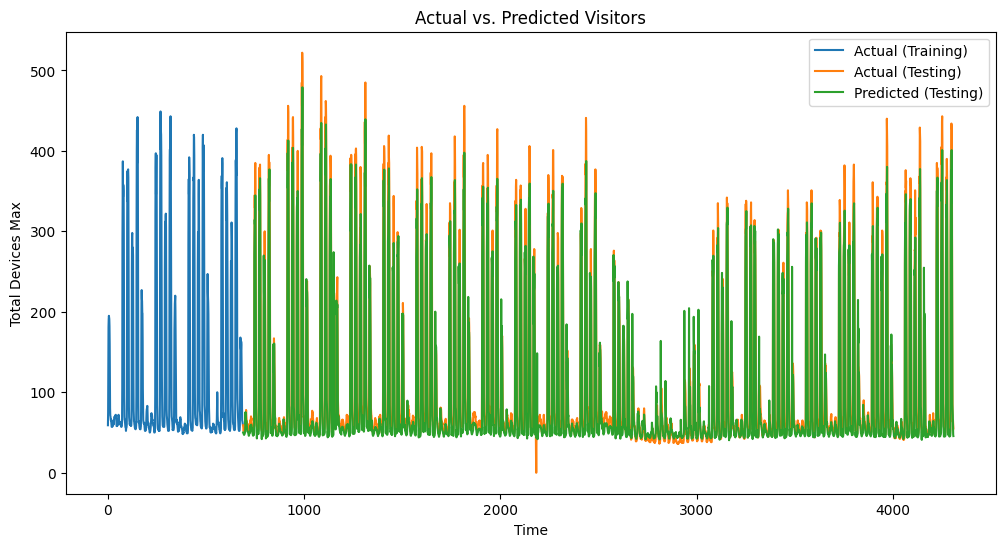

Mean Squared Error (MSE): 429.61724767474783
Root Mean Squared Error (RMSE): 20.7272103206087
Minimum value: 0
Maximum value: 522
Range: 522
Mean Absolute Percentage Error (MAPE): inf%
R-squared (Coefficient of Determination): 0.9584921847067389


C:\Users\mario\AppData\Local\Temp\ipykernel_446332\40871673.py:92: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100


In [34]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.84, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")#model.save("wifidata_model_hourly.h5")

In [35]:
wifi_data = pd.read_csv("../data/RAW WiFi Data 8 months.csv", low_memory=False)

In [36]:
wifi_data = wifi_data[['Date Time', 'Total Online Devices']]
wifi_data = wifi_data.drop(wifi_data.index[-1])
wifi_data.tail()

,Date Time,Total Online Devices
5083,30-4-2024 18:00:00 - 19:00:00,94 #
5084,30-4-2024 19:00:00 - 20:00:00,75 #
5085,30-4-2024 20:00:00 - 21:00:00,74 #
5086,30-4-2024 21:00:00 - 22:00:00,69 #
5087,30-4-2024 22:00:00 - 23:00:00,63 #


In [37]:
wifi_data = wifi_data.dropna()
wifi_data.isna().sum()

Date Time               0
Total Online Devices    0
dtype: int64

In [38]:
from datetime import datetime
def convert_to_datetime(row):
    datetime_string = row.split(" - ")[0]
    datetime_format = "%d-%m-%Y %H:%M:%S"
    return datetime.strptime(datetime_string, datetime_format)

In [39]:
wifi_data['Date Time'] = wifi_data['Date Time'].apply(convert_to_datetime)

In [40]:
wifi_data.head()

,Date Time,Total Online Devices
0,2023-09-01 00:00:00,61 #
1,2023-09-01 01:00:00,58 #
2,2023-09-01 02:00:00,57 #
3,2023-09-01 03:00:00,57 #
4,2023-09-01 04:00:00,57 #


In [41]:
wifi_data['Total Online Devices'] = wifi_data['Total Online Devices'].str.replace('#','').astype(int)

In [42]:
wifi_data.head()

,Date Time,Total Online Devices
0,2023-09-01 00:00:00,61
1,2023-09-01 01:00:00,58
2,2023-09-01 02:00:00,57
3,2023-09-01 03:00:00,57
4,2023-09-01 04:00:00,57


In [43]:
wifi_data.dtypes

Date Time               datetime64[ns]
Total Online Devices             int32
dtype: object

In [44]:
dt = wifi_data['Date Time']
devices = wifi_data['Total Online Devices']

new_data_wifi_df = pd.DataFrame({'datetime': dt, 'totaldevices': devices})

new_data_wifi_df = new_data_wifi_df[new_data_wifi_df['datetime'] != 'Averages']

new_data_wifi_df['datetime'] = pd.to_datetime(new_data_wifi_df['datetime'], format='%d-%m-%Y')

grouped_data = new_data_wifi_df.groupby('datetime').agg({'totaldevices': ['mean', 'max', 'min']})
grouped_data.columns = grouped_data.columns.map(''.join)

total_devices_sum = new_data_wifi_df.groupby('datetime')['totaldevices'].sum()

sorted_grouped_wifi_data = pd.merge(grouped_data, total_devices_sum, left_index=True, right_index=True)

sorted_grouped_wifi_data.rename(columns={'totaldevices': 'totaldevicessum'}, inplace=True)

sorted_grouped_wifi_data = sorted_grouped_wifi_data.sort_index()

sorted_grouped_wifi_data.tail()

,totaldevicesmean,totaldevicesmax,totaldevicesmin,totaldevicessum
datetime,,,,
2024-04-30 18:00:00,94.0,94,94,94
2024-04-30 19:00:00,75.0,75,75,75
2024-04-30 20:00:00,74.0,74,74,74
2024-04-30 21:00:00,69.0,69,69,69
2024-04-30 22:00:00,63.0,63,63,63


In [45]:
wifi = sorted_grouped_wifi_data.copy()

Splitting the test data for a month:

[[[ 61]
  [ 58]
  [ 57]
  ...
  [ 57]
  [ 58]
  [ 58]]

 [[ 58]
  [ 57]
  [ 57]
  ...
  [ 58]
  [ 58]
  [ 59]]

 [[ 57]
  [ 57]
  [ 57]
  ...
  [ 58]
  [ 59]
  [ 75]]

 ...

 [[373]
  [363]
  [326]
  ...
  [161]
  [ 94]
  [ 75]]

 [[363]
  [326]
  [242]
  ...
  [ 94]
  [ 75]
  [ 74]]

 [[326]
  [242]
  [161]
  ...
  [ 75]
  [ 74]
  [ 69]]]
LSTM Model Test Loss: 261.7901916503906
32/32 [==============================] - 0s 1ms/step


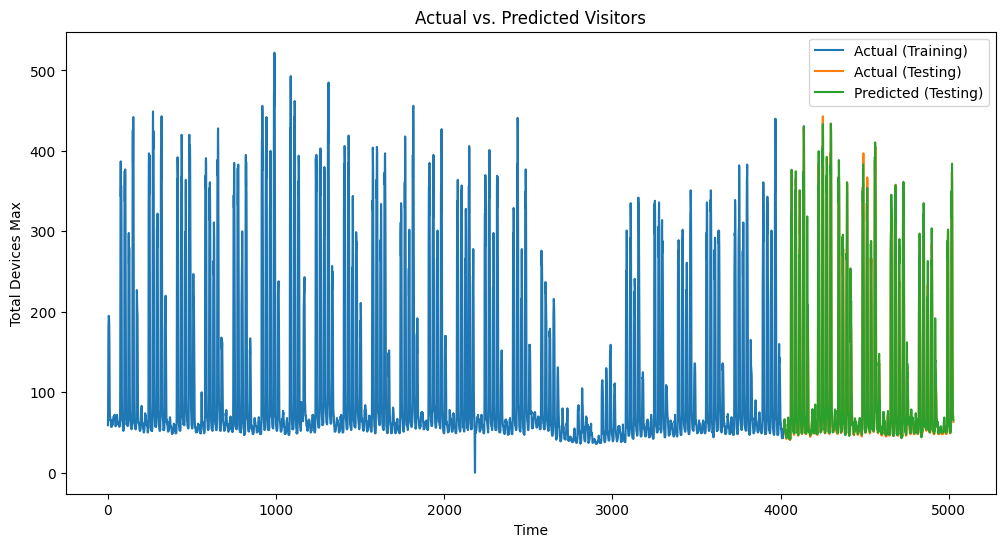

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()

In [47]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

Mean Squared Error (MSE): 261.79019754522506
Root Mean Squared Error (RMSE): 16.17993193883167
Minimum value: 41
Maximum value: 443
Range: 402
Mean Absolute Percentage Error (MAPE): 7.104973128447532%
R-squared (Coefficient of Determination): 0.9753951422056398


Splitting the test data for 2 months:

LSTM Model Test Loss: 184.82650756835938
52/52 [==============================] - 0s 1ms/step


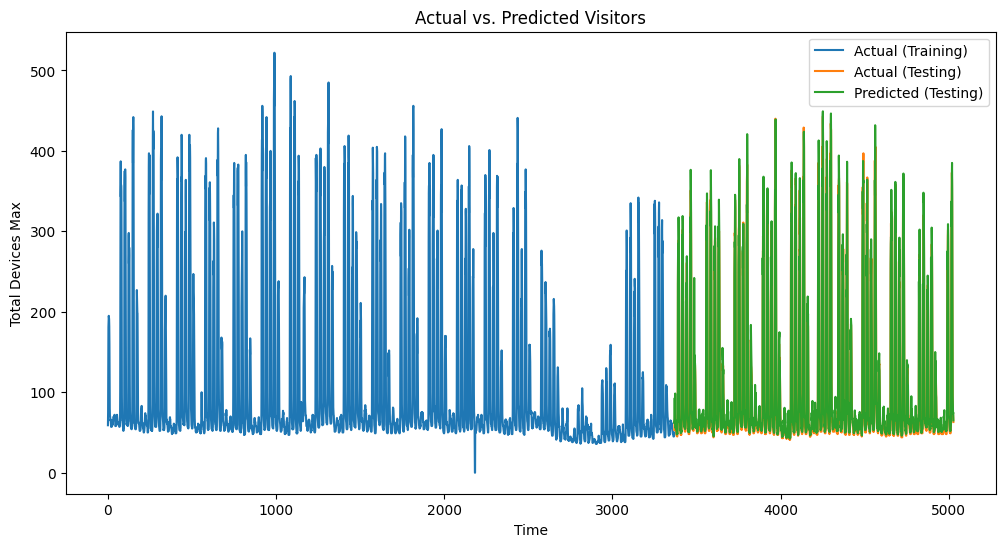

Mean Squared Error (MSE): 184.826576616372
Root Mean Squared Error (RMSE): 13.595093843602992
Minimum value: 41
Maximum value: 443
Range: 402
Mean Absolute Percentage Error (MAPE): 8.808887286683415%
R-squared (Coefficient of Determination): 0.9814613918090278


In [48]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")#model.save("wifidata_model_hourly.h5")

Splitting the test data for 3 months:

LSTM Model Test Loss: 256.2360534667969
79/79 [==============================] - 0s 1ms/step


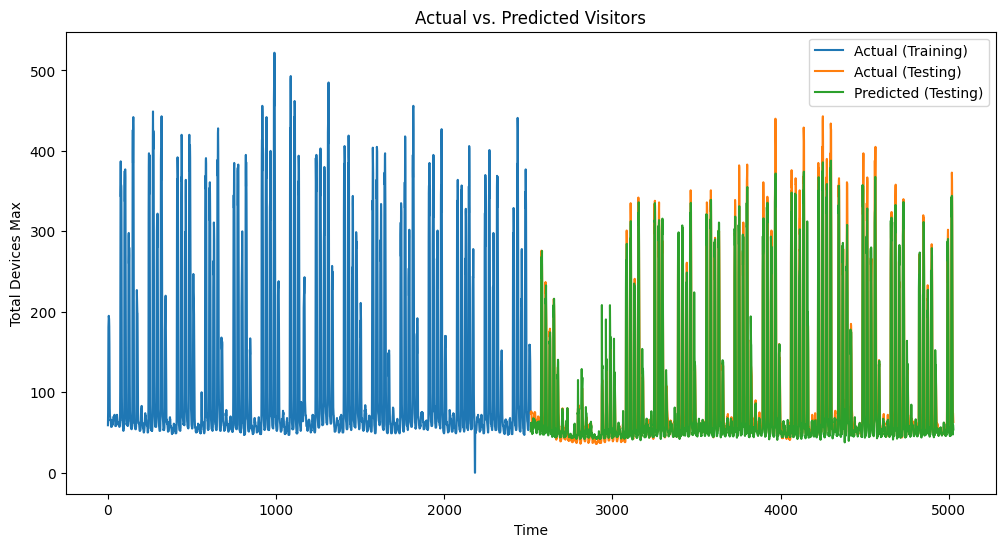

Mean Squared Error (MSE): 256.2360532996133
Root Mean Squared Error (RMSE): 16.007374965921592
Minimum value: 36
Maximum value: 443
Range: 407
Mean Absolute Percentage Error (MAPE): 9.862584509395255%
R-squared (Coefficient of Determination): 0.9688315502850877


In [49]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")

In [50]:
#model.save("wifidata_model_hourly.h5")

Splitting the test data for 4 months:

LSTM Model Test Loss: 617.6127319335938
106/106 [==============================] - 0s 1ms/step


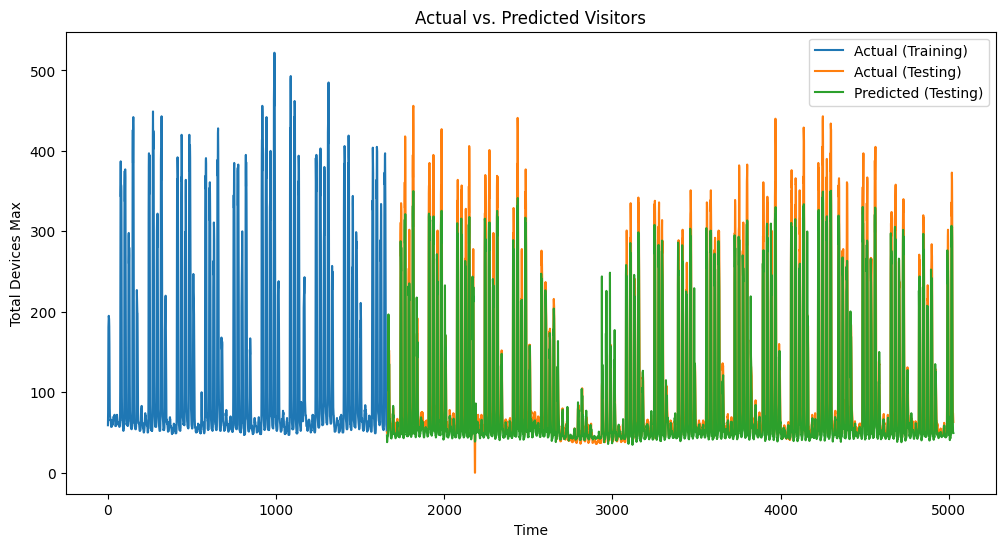

Mean Squared Error (MSE): 617.6127120463959
Root Mean Squared Error (RMSE): 24.851815065431257
Minimum value: 0
Maximum value: 456
Range: 456
Mean Absolute Percentage Error (MAPE): inf%
R-squared (Coefficient of Determination): 0.9302881539867094


C:\Users\mario\AppData\Local\Temp\ipykernel_446332\802077054.py:93: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100


In [51]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.67, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")#model.save("wifidata_model_hourly.h5")

Splitting the test data for 5 months:

LSTM Model Test Loss: 568.34765625
132/132 [==============================] - 0s 1ms/step


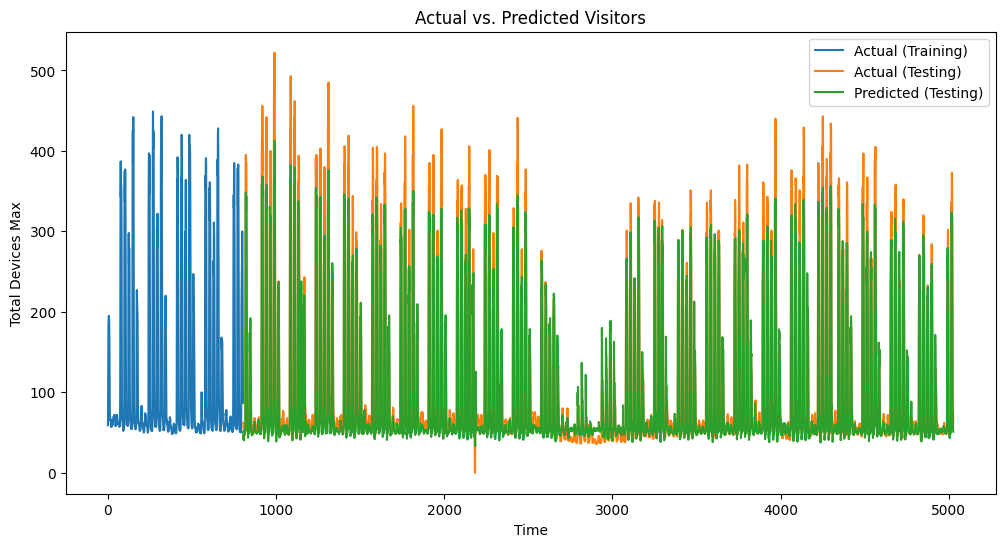

Mean Squared Error (MSE): 568.3476147970551
Root Mean Squared Error (RMSE): 23.840042256612197
Minimum value: 0
Maximum value: 522
Range: 522
Mean Absolute Percentage Error (MAPE): inf%
R-squared (Coefficient of Determination): 0.9435181216376366


C:\Users\mario\AppData\Local\Temp\ipykernel_446332\40871673.py:92: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100


In [52]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

scaled_data = wifi['totaldevicesmax'].values.reshape(-1, 1)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences for LSTM input
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.84, shuffle=False)

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the actual values for plotting
actual_values = y_test.reshape(-1, 1)

# Plot actual vs. predicted visitor numbers
y_train_actual = y_train.reshape(-1, 1)

train_length = len(y_train_actual)

plt.figure(figsize=(12, 6))
plt.plot(range(train_length), y_train_actual, label='Actual (Training)')

plt.plot(range(train_length, train_length+len(actual_values)), actual_values, label='Actual (Testing)')
plt.plot(range(train_length, train_length+len(predictions)), predictions, label='Predicted (Testing)')

plt.title('Actual vs. Predicted Visitors')
plt.xlabel('Time')
plt.ylabel('Total Devices Max')
plt.legend()
plt.show()
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'actual_values' and 'predictions' are your actual and predicted values
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate additional metrics for the 'Visitors' value
actual_values = np.array(actual_values)
predictions = np.array(predictions)

# Minimum value
min_value = np.min(actual_values)
print(f"Minimum value: {min_value}")

# Maximum value
max_value = np.max(actual_values)
print(f"Maximum value: {max_value}")

# Range
range_value = max_value - min_value
print(f"Range: {range_value}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values, predictions)
print(f"R-squared (Coefficient of Determination): {r2}")#model.save("wifidata_model_hourly.h5")